# DATA 558 - Polished Code Assignment
### Simulated Data Demo
Will Wright
***

In this notebook, we'll explore the creation and application of an $\ell_2^2$-regularized logistic regression classifier on simulated data. Logistic regression is a generalized linear model used to classify categorical data such as hit/miss, true/false, or hotdog/not hotdog. It works by assigning weights in a model that maximize the likelihood of achieving the same labels as the training data. The model uses a sigmoidal link function to give it its distinct S-shaped curve, which works well with classification log-likelihood. This model is then optimized through Nesterov's accelerated gradient descent. It's worth noting that the $\ell_2^2$-regularized component penalizes the loss function and is used to find an optimal balance between bias and variance during cross-validation such that the model generalizes well to new data.

Below, we'll explore each of these steps and illustrate how this incredibly useful tool works with simulated data.

In [163]:
# Load Packages

import numpy as np
import pandas as pd
from random import sample
from random import choice
import scipy.linalg
import copy
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
%matplotlib inline

To start, a 2D simulated dataset is created where $x_1$ and $x_2$ are sampled from a normal distribution with means of 2 and -2 (for separation) and standard deviations of 1. The colors in the plot denote the two categories of data.

In [173]:
np.random.seed(20190607)
n=1000
x1 = np.random.normal(1.5,1,(n,2))
x2 = np.random.normal(-1.5,1,(n,2))

In [174]:
sim_features = np.vstack((x1, x2))
sim_labels = np.hstack((-np.ones(n),np.ones(n))).reshape(2*n,1)

In [175]:
print(sim_features.shape)
print(sim_labels.shape)

(2000, 2)
(2000, 1)


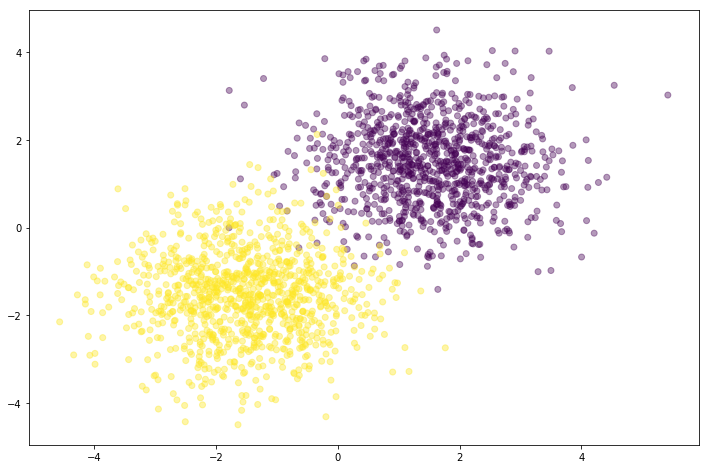

In [177]:
plt.figure(figsize=(12,8))
plt.scatter(sim_features[:, 0], sim_features[:, 1],
            c = sim_labels[:, 0], alpha = .4)

Next, the logistic objective function and its gradient are needed.

Logistic objective function with $\ell_2^2$-regularization penalty:
$$\min_{\mathbf{\beta \in \mathbb{R}^d}} F(\beta):=\frac{1}{n}\sum_{i=1}^{n} log(1+exp(-y_ix_i^T\beta)) + \lambda\lVert\beta\rVert_2^2$$  
It's gradient is:  
$$\nabla F(\beta) = -\frac{1}{n}\sum_{i=1}^{n}y_ix_i \cdot \frac{exp(-y_ix_i^T\beta)}{1+exp(-y_ix_i^T\beta)} + 2\lambda \beta$$

In code-format, the objective and gradient are expressed as functions *compute_obj* and *compute_grad*, respectively:

In [389]:
def compute_obj(beta, lamb, x, y):
    'outputs the logistic objective function value for a given set of betas, lambda, x features, and y labels'
    obj = 1/len(y) * np.sum(np.log(1 + np.exp(-y*x.dot(beta)))) + lamb*np.linalg.norm(beta)**2
    return obj

def compute_grad(beta, lamb, x, y):
    'outputs the gradient for a given set of betas, lambda, x features, and y labels'
    grad = -1/len(y)*np.sum(y*x*np.exp(-y*x.dot(beta))/(1+np.exp(-y*x.dot(beta)))) + 2*lamb*beta
    return grad

In order to optimize $\beta$, we'll use Nesterov's accelerated gradient descent.  This is an algorithm for convex functions which moves in the direction of the gradient (toward optimization/convergence) with a dynamic step-size which is larger when further away from convergence and gets progressively smaller on approach so as to not overshoot.  This algorithm is called _backtracking_ and is defined below.

In [380]:
def backtracking(beta, lamb, x, y, eta, alpha=0.5, gamma=0.8):
    '''initialize with given beta, lambda, x features, y labels, 
        eta (step-size), alpha (threshold), and gamma (eta size reducer)
    output is updated eta'''
    grad_beta = compute_grad(beta, lamb, x=x, y=y)
    found_eta = False
    iter = 0
    while found_eta == False and iter < 1000:
        if compute_obj(beta - eta * grad_beta, lamb, x=x, y=y) < \
            compute_obj(beta, lamb, x=x, y=y)- alpha * eta * np.linalg.norm(grad_beta)**2:
                found_eta = True
        else:
            eta *= gamma
            iter +=1
    return eta

Importantly, the initial step size shouldn't be too large or too small, else it'll take more iterations to converge by either taking too many small steps or large steps which are constantly overshooting.  The following initialization for eta ensures a relevant start.

In [381]:
def compute_eta_init(x, y, lamb):
    eta_init = 1/(scipy.linalg.eigh(1/len(y)*x.T.dot(x),
                                eigvals=(d-1, d-1),
                                eigvals_only=True)[0]+lamb)
    return eta_init

Given all the above pieces, we now put them together in the accelerated gradient descent algorithm:

In [395]:
def mylogistic(x, y, beta_init, theta_init, lamb, eta_init, eps):
    'outputs beta values and objective values per iteration until convergence'
    beta = beta_init
    theta = theta_init
    eta = eta_init
    grad_theta = compute_grad(theta, lamb, x=x, y=y)
    grad_beta = compute_grad(beta, lamb, x=x, y=y)
    beta_vals = beta
    obj_vals = np.empty((0,1))
    iter = 0
    while np.linalg.norm(grad_beta) > eps:
        print(iter)
        eta = backtracking(theta, lamb, x=x, y=y, eta = eta)
        beta_new = theta - eta*grad_theta
        theta = beta_new + iter/(iter+3)*(beta_new-beta)
        obj = compute_obj(beta, lamb, x=x, y=y)
        print(obj)
        beta_vals = np.vstack((beta_vals, beta))
        obj_vals = np.vstack((obj_vals, obj))
        grad_theta = compute_grad(theta, lamb, x=x, y=y)
        grad_beta = compute_grad(beta, lamb, x=x, y=y)
        beta = beta_new
        iter += 1
    return beta_vals, obj_vals

To test it out, we'll initialize with $\lambda = 1$, beta and theta vectors as 0s, and a reasonable step-size.

In [383]:
n,d = sim_features.shape
lamb = 1
beta_init = np.zeros((d,1))
theta_init = np.zeros((d,1))
eta_init = computeEtaInit(sim_features, sim_labels, lamb)
eps = 10**-3

In [396]:
beta_vals, obj_vals = mylogistic(sim_features, sim_labels, beta_init, theta_init, lamb, eta_init, eps)

0
0.6931471805599454
1
0.540343550648326
2
0.5208616948327028
3
0.5315275649653701
4
0.5481248436712054
5
0.5599597627536701
6
0.5651852420567143
7
0.5657729745207017
8
0.5642765298495878
9
0.5624735345071314
10
0.5611937205082177


Welp. I guess I'll submit now and hope I still have an extension because this problem (the problem I've had all course) seem endemic to all my work.  I don't understand why I can't get convergence and nothing I've tried (even taking other code for the subroutines to see what's wrong) yields the same results.  
I guess I needed 1:1 help to review my code, but I didn't have anyone and no tutors were available. Feelsbadman.  Here's hoping I pass...